<a href="https://colab.research.google.com/github/Ahmadsaidnouh/Term7-Artificial-Intelligence-Assignments/blob/lab4%2Fhossam/lab4/jupyter%20notebooks/Finallllllll_NLP_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install transformers
%pip install pandas 
%pip install torch
%pip install tqdm
%pip install nltk
%pip install configparser

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
import gc
import configparser
import ast
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# For first run

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# For mounting another drive

In [4]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [5]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 129507 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


In [6]:
df_train = pd.read_csv(f"/content/drive/MyDrive/Lab4_Data/train.csv")
df_val = pd.read_csv(f"/content/drive/MyDrive/Lab4_Data/val.csv")
df_test = pd.read_csv(f"/content/drive/MyDrive/Lab4_Data/test.csv")
# df_train = df_train[0:5000]
# df_val = df_val[0:715]
# df_test = df_test[0:1430]


print(len(df_train), len(df_val), len(df_test))
df_train


35000 5000 10000


,review,sentiment
0,yep lot shouting screaming cheering arguing ce...,negative
1,1st watched 832003 2 10dirbrad sykes mindless ...,negative
2,think movie probably lot powerful first debute...,positive
3,ive read lot review imdb well five one written...,negative
4,got usenet wasnt prepared heavy mean exception...,negative
...,...,...
34995,ralph bakshi film appear like twoedged sword y...,positive
34996,one favorite movie time great acting brilliant...,positive
34997,thinking cannes one irritating film time every...,negative
34998,cinema 60 much time revolution politics music ...,positive


In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
labels = {
    "negative" : 0 ,
    "positive" : 1,
}


class Dataset(torch.utils.data.TensorDataset):
    def __init__(self, df):

        self.labels = [labels[label] for label in df["sentiment"]]
        # self.labels = []
        # for label in df["sentiment"]:
        #     self.labels.append(label)
        self.texts = [
            tokenizer(
                text,
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            )
            for text in df["review"]
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [8]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_bert = nn.Dropout(0.5)
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(768, 512)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, 256)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 64)
        self.linear_out = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):
        _, x = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        x = self.dropout_bert(x)
        x = self.relu1(self.linear1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu2(self.linear2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu3(self.linear3(x))
        x = self.dropout(x)
        x = self.relu4(self.linear4(x))
        x = self.dropout(x)
        x = self.sigmoid(self.linear_out(x))
        return x


In [9]:
def save_checkpoint(model, epoch, optimizer, best_acc, model_path):
  state = {
      'epoch' : epoch + 1,
      'model' : model.state_dict(),
      'best accuracy' : best_acc,
      'optimizer' : optimizer.state_dict()
  }
  torch.save(state, model_path)

In [10]:
batch_size=16   
trainn, val, test = Dataset(df_train), Dataset(df_val), Dataset(df_test)

In [11]:
trainn

In [12]:
train_dataloader = torch.utils.data.DataLoader(trainn, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

In [13]:
epoch_list = list()
train_loss = list()
val_loss = list()
train_accuracy = list()
val_accuracy = list()

config_file = '/content/drive/MyDrive/Lab4_Data/config_1e6.ini'

try:
    # Load variables from config file
    config = configparser.ConfigParser()
    config.read(config_file)

    epoch_list = ast.literal_eval(config['VARIABLES']['epoch_list'])
    train_loss = ast.literal_eval(config['VARIABLES']['train_loss'])
    val_loss = ast.literal_eval(config['VARIABLES']['val_loss'])
    train_accuracy = ast.literal_eval(config['VARIABLES']['train_accuracy'])
    val_accuracy = ast.literal_eval(config['VARIABLES']['val_accuracy'])

    print(epoch_list)
    print(train_loss)
    print(val_loss)
    print(train_accuracy)
    print(val_accuracy)

except:
    print(f"Error while reading config file {config_file}")
    # Save variables to config file
    config = configparser.ConfigParser()
    config['VARIABLES'] = {'epoch_list': '[]',
                          'train_loss': '[]',
                          'val_loss': '[]',
                           'train_accuracy': '[]',
                           'val_accuracy': '[]'}

    with open(config_file, 'w') as configfile:
        config.write(configfile)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.03805524226852826, 0.018507888248349938, 0.012650537067172783, 0.00931119407758649, 0.007130072345983769, 0.005714839274981724, 0.004773867509427613, 0.004062701126547264, 0.003590918951135661, 0.0031402061021920027]
[0.023019296556711196, 0.018190362490713596, 0.018719605883955954, 0.017590423609316348, 0.01978865383323282, 0.020838822490163146, 0.0207795081526041, 0.022163162409560754, 0.022950338547397406, 0.02358819275330752]
[0.6658285714285714, 0.8966571428571428, 0.9285428571428571, 0.9522285714285714, 0.9662857142857143, 0.9744, 0.9806571428571429, 0.9840285714285715, 0.9862571428571428, 0.9887428571428571]
[0.8838, 0.8778, 0.8834, 0.9052, 0.9006, 0.9026, 0.9052, 0.9064, 0.9078, 0.9112]


In [14]:
def plot_all():
    plt.figure(figsize = [18, 5])
    plt.suptitle("Loss and Accuracy in training")
    plt.subplot(1,2,1)
    plt.plot(epoch_list,train_loss);
    plt.plot(epoch_list,val_loss);
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train","Validation"])
    plt.subplot(1,2,2)
    plt.plot(epoch_list,train_accuracy);
    plt.plot(epoch_list,val_accuracy);
    plt.xlabel("Epochs");
    plt.ylabel("Accuracy")
    plt.legend(["Train","Validation"]);
    plt.show()
    

In [15]:
def train(model,train_data, val_data, train_dataloader, val_dataloader, learning_rate, epochs, bach_size, best_model_path, last_model_path,start_from_epoch = 0):                    
    # Early stopping
    val_avg_acc_best = 0.9039999999999999
    try:
      val_acc_best = max(val_accuracy)
    except:
      val_acc_best = -1000
      print("empty")

    print("Val_best_acc = ", val_acc_best)
    early_stop_items_num = 5

    
    device = torch.device("cuda")

    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    model = model.cuda()
    criterion = criterion.cuda()

    try:
      print("Check saved model")
      loaded_checkpoint = torch.load(last_model_path)
      model.load_state_dict(loaded_checkpoint["model"])
      optimizer.load_state_dict(loaded_checkpoint["optimizer"])
      print("Loaded saved model")
    except:
      print("No saved models")

    for epoch_num in range(start_from_epoch,epochs):
            gc.collect()

            model.train()
            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):
                gc.collect()
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)

                batch_loss = criterion(output.squeeze(1), train_label.float())
                total_loss_train += batch_loss.item()

                y_pred_tag = torch.round(output.squeeze(1))
                acc = (y_pred_tag == train_label).sum()

                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0
            model.eval()
            with torch.no_grad():

                for val_input, val_label in val_dataloader:
                    gc.collect()
                    # torch.cuda.empty_cache()

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output.squeeze(1), val_label.float())
                    total_loss_val += batch_loss.item()
                    
                    y_pred_tag = torch.round(output.squeeze(1))
                    acc = (y_pred_tag == val_label).sum()
                    total_acc_val += acc
            
            train_loss.append(total_loss_train / len(train_data))
            train_accuracy.append(total_acc_train.item() / len(train_data))
            val_loss.append(total_loss_val / len(val_data))
            val_accuracy.append(total_acc_val.item() / len(val_data))
            epoch_list.append(epoch_num+1)
            val_acc_new = total_acc_val / len(val_data)
            
            
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            
            
            if val_acc_new > val_acc_best:
              val_acc_best = val_acc_new
              save_checkpoint(model, epoch_num, optimizer, val_acc_best, best_model_path)

            save_checkpoint(model, epoch_num, optimizer, val_acc_new, last_model_path)
            
            current_avg_acc = sum(val_accuracy[-early_stop_items_num:])/early_stop_items_num
            val_avg_acc_best = max(val_avg_acc_best, current_avg_acc)
            if epoch_num == start_from_epoch:
              old_avg_acc = current_avg_acc
              
            print("Val_accuracy = ", val_accuracy)
            print("Val_accuracy = ", val_accuracy[-early_stop_items_num:])
            print("current_avg_acc = ", current_avg_acc)
            print("val_avg_acc_best = ", val_avg_acc_best)
            print("Difference = ", (val_avg_acc_best - current_avg_acc))
            print("*************************************************************************************************************\n")

            
            the_current_loss = total_loss_val / len(val_data)
            the_last_loss = the_current_loss
            config.update({'VARIABLES':{
                            'train_loss':train_loss,
                            'val_loss':val_loss,
                            'train_accuracy':train_accuracy,
                            'val_accuracy':val_accuracy,
                            'epoch_list':epoch_list}})
            with open(config_file, 'w') as configfile:
                config.write(configfile)

            # Early stopping
            if len(val_accuracy) >= early_stop_items_num and (((val_avg_acc_best - current_avg_acc) >= 0.04) or ((epoch_num - start_from_epoch) >=2 and abs(old_avg_acc - current_avg_acc) <= 0.02)):
                print("Early stopping at epoch:", epoch_num+1)
                break      

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start epoch =  10
Val_best_acc =  0.9112
Check saved model
Loaded saved model


100%|██████████| 2188/2188 [1:01:10<00:00,  1.68s/it]


Epochs: 11 | Train Loss:  0.003                 | Train Accuracy:  0.991                 | Val Loss:  0.024                 | Val Accuracy:  0.909
Val_accuracy =  [0.8838, 0.8778, 0.8834, 0.9052, 0.9006, 0.9026, 0.9052, 0.9064, 0.9078, 0.9112, 0.909]
Val_accuracy =  [0.9052, 0.9064, 0.9078, 0.9112, 0.909]
current_avg_acc =  0.9079200000000001
val_avg_acc_best =  0.9079200000000001
Difference =  0.0
*************************************************************************************************************



100%|██████████| 2188/2188 [1:01:24<00:00,  1.68s/it]


Epochs: 12 | Train Loss:  0.003                 | Train Accuracy:  0.991                 | Val Loss:  0.026                 | Val Accuracy:  0.912
Val_accuracy =  [0.8838, 0.8778, 0.8834, 0.9052, 0.9006, 0.9026, 0.9052, 0.9064, 0.9078, 0.9112, 0.909, 0.9116]
Val_accuracy =  [0.9064, 0.9078, 0.9112, 0.909, 0.9116]
current_avg_acc =  0.9092
val_avg_acc_best =  0.9092
Difference =  0.0
*************************************************************************************************************



100%|██████████| 2188/2188 [1:01:28<00:00,  1.69s/it]


Epochs: 13 | Train Loss:  0.002                 | Train Accuracy:  0.992                 | Val Loss:  0.025                 | Val Accuracy:  0.915
Val_accuracy =  [0.8838, 0.8778, 0.8834, 0.9052, 0.9006, 0.9026, 0.9052, 0.9064, 0.9078, 0.9112, 0.909, 0.9116, 0.9152]
Val_accuracy =  [0.9078, 0.9112, 0.909, 0.9116, 0.9152]
current_avg_acc =  0.91096
val_avg_acc_best =  0.91096
Difference =  0.0
*************************************************************************************************************

Early stopping at epoch: 13


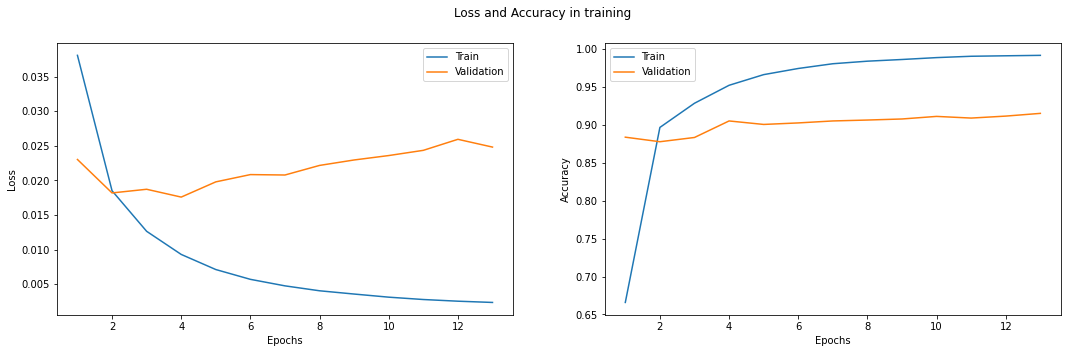

In [16]:
EPOCHS = 10000
LR = 5e-6

model = BertClassifier()



best_model_path = f"/content/drive/MyDrive/Lab4_Data/model_best.pth.tar"
last_model_path = f"/content/drive/MyDrive/Lab4_Data/model_last.pth.tar"
gc.collect()

epoch_num = 0

if len(epoch_list) != 0:
  epoch_num = epoch_list[-1]
print("Start epoch = ",epoch_num)
train(model,df_train, df_val, train_dataloader, val_dataloader, LR, EPOCHS,batch_size, best_model_path, last_model_path,start_from_epoch = epoch_num)
plot_all()

In [17]:
# print(train_loss)
# print(train_accuracy)
# print(val_loss)
# print(val_accuracy)

# print(epoch_list)

In [18]:
# from sklearn.metrics import confusion_matrix

# def evaluate(model, test_data, test_dataloader):

#     use_cuda = torch.cuda.is_available()
#     device = torch.device("cuda" if use_cuda else "cpu")
#     final_confusion_matrix = np.zeros([2,2])

#     if use_cuda:

#         model = model.cuda()

#     total_acc_test = 0
#     model.eval()
#     with torch.no_grad():

#         for test_input, test_label in test_dataloader:
#               test_label = test_label.to(device)
#               # print(test_label)
#               mask = test_input['attention_mask'].to(device)
#               input_id = test_input['input_ids'].squeeze(1).to(device)
#               output = model(input_id, mask)
#               y_pred_tag = torch.round(output.argmax(dim=1))
#               # print(y_pred_tag)
#               for i in range(len(input_id)):
#                 tokens = tokenizer.convert_ids_to_tokens(input_id[i])
#                 text = tokenizer.convert_tokens_to_string(tokens)
#                 text = text.replace('[CLS] ','').replace(' [SEP]  ','').replace('[PAD]','')
#                 # print(text + " | Output : "+ labels[y_pred_tag.cpu().data.numpy()[i]] + " | Actual : " + labels[test_label.cpu().data.numpy()[i]])
              
#               acc = (y_pred_tag == test_label).sum()
#               total_acc_test += acc
#               final_confusion_matrix += confusion_matrix(test_label.cpu().data.numpy(), y_pred_tag.cpu().data.numpy())
    
#     TP = final_confusion_matrix[0][0]
#     FP = final_confusion_matrix[0][1]
#     FN = final_confusion_matrix[1][0]
#     TN = final_confusion_matrix[1][1]
#     Percision = TP/(TP+FP)
#     Recall = TP/(TP+FN)
#     print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
#     print(f'Percision : {Percision}')
#     print(f'Sensitivity (Recall) : {Recall}')
#     print(f'Specifity : {TN/(TN+FP)}')
#     print(f'F1 Score = {((2*Percision*Recall)/(Percision+Recall))}')
#     print('Confusion Matrix :')
#     print(final_confusion_matrix)
    


In [19]:
# loaded_checkpoint = torch.load(best_model_path)
# model = BertClassifier()
# model.load_state_dict(loaded_checkpoint["model"])

In [20]:
# evaluate(model, df_test, test_dataloader)